In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
%matplotlib inline

In [2]:
import talib
from ta import add_all_ta_features

### Read full database

In [5]:
DATA_PATH = r'../data/'
FILE_NAME = '20220313_034756_111.pkl'
FULL_PATH = Path(DATA_PATH,FILE_NAME)

In [35]:
%time
raw = pd.read_pickle(FULL_PATH)
raw.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


(5675397, 14)

In [37]:
raw.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                                object
high                                object
low                                 object
close                               object
volume                              object
numTrades                            int64
quoteAssetVolume                    object
takerBuyBaseAssetVolume             object
takerBuyQuoteAssetVolume            object
dtype: object

In [38]:
raw.symbol.value_counts()

BTCUSDT     87964
ETHUSDT     80325
BCHUSDT     78208
XRPUSDT     76486
EOSUSDT     76292
            ...  
BAKEUSDT    28582
BTTUSDT     28339
GTCUSDT     26390
TLMUSDT     23032
KEEPUSDT    22843
Name: symbol, Length: 111, dtype: int64

### Prepare and subset dataset

In [265]:
df = raw.query('symbol=="ETHUSDT"')
assert df.isnull().sum().sum() == 0
df.shape

(80325, 14)

In [266]:
# create datatypes dictionary
datatypes = {k:'float32' if k!='numTrades' else 'int32' for k in df.loc[:,'open':].columns}
# assign datatypes
df = df.astype(datatypes)
assert df.isnull().sum().sum() == 0
df.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                               float32
high                               float32
low                                float32
close                              float32
volume                             float32
numTrades                            int32
quoteAssetVolume                   float32
takerBuyBaseAssetVolume            float32
takerBuyQuoteAssetVolume           float32
dtype: object

In [268]:
df.to_pickle('../data/eth.pkl')

### Read dataset from disk

In [3]:
raw = pd.read_pickle('../data/eth.pkl')

### Group on desired frequency

In [492]:
df = \
    raw.groupby(pd.Grouper(key="openTime", freq="1H"))\
    .agg(
        cnt=pd.NamedAgg(column="symbol", aggfunc="size"),
        opentime=pd.NamedAgg(column="openTime", aggfunc="min"),
        closetime=pd.NamedAgg(column="openTime", aggfunc="min"),
        open=pd.NamedAgg(column="open", aggfunc="first"),
        high=pd.NamedAgg(column="high", aggfunc="max"),
        low=pd.NamedAgg(column="low", aggfunc="min"),
        close=pd.NamedAgg(column="close", aggfunc="last"),
        volume=pd.NamedAgg(column="volume", aggfunc="sum"),
        numtrade=pd.NamedAgg(column="numTrades", aggfunc="sum"),
    )\
    .query('cnt >= 4')\
    .drop('cnt',axis=1)\
    .assign(closetime = lambda x : x.closetime + pd.Timedelta(minutes=59))\
    .reset_index(drop=True)

# alternative way to resample and regroup data
# df = raw.resample('30min',on='opentime').agg({'close':'last','high':'max'}).tail(10)
df.tail()

,opentime,closetime,open,high,low,close,volume,numtrade
20076,2022-03-12 20:00:00,2022-03-12 20:59:00,2576.760010,2591.659912,2573.870117,2586.800049,25150.187500,35923
20077,2022-03-12 21:00:00,2022-03-12 21:59:00,2586.800049,2591.719971,2583.060059,2585.649902,13017.638672,24267
20078,2022-03-12 22:00:00,2022-03-12 22:59:00,2585.649902,2591.379883,2583.260010,2585.830078,10603.583008,26367
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,49081
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,50466


### Inspect Time Series

count                  20081
mean     2021-01-18 16:00:00
min      2019-11-27 08:00:00
25%      2020-06-23 12:00:00
50%      2021-01-18 16:00:00
75%      2021-08-15 20:00:00
max      2022-03-13 00:00:00
Name: opentime, dtype: object
AxesSubplot(0.125,0.125;0.775x0.755)


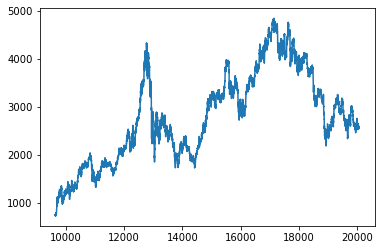

In [493]:
print(df.opentime.describe(datetime_is_numeric=True))
# print(df.close.plot())
print(df.query('opentime >= 2021').close.plot())

In [494]:
df = df.query('opentime >= 2021').copy()
df.shape

(10465, 8)

### Decompose Time Series

In [495]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# # from statsmodels.tsa.seasonal import MSTL
# print(plot_acf(df.close))
# print(plot_pacf(df.close))
# # stl_kwargs = {"seasonal_deg": 0} 
# # model = MSTL(df.close, periods=(24, 24 * 7), stl_kwargs=stl_kwargs)
# # res = model.fit()
# # res.plot()

### Create Features to Avoid Leakage
> __close -> fx_close = close.shift(1)__

In [496]:
options_antileakage_feats = ['open','high','low','close','volume']
for ff in options_antileakage_feats:
    df[f'fx_{ff}'] = df[ff].shift(ll)

In [497]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume'],
      dtype='object')

### Create Lag Features

In [498]:
options_lags_feats = ['close','volume']
options_lags = [1,2,3,24,48]
for ff in options_lags_feats:
    for ll in options_lags:
        df[f'fx_{ff}_lag_{str(ll).zfill(3)}'] = df[ff].shift(ll)

In [499]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048'],
      dtype='object')

In [500]:
df.shape

(10465, 23)

### Create Diff Features

In [501]:
options_diffs_feats = ['fx_close','fx_volume']
options_diffs = [1,2,3,24,48]
for ff in options_diffs_feats:
    for ll in options_diffs:
        df[f'{ff}_diff_{str(ll).zfill(3)}'] = df[ff].diff(ll)

In [502]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048'],
      dtype='object')

In [503]:
df.shape

(10465, 33)

### Create Rolling Features

In [504]:
options_wndf_feats = ['fx_close','fx_volume']
options_wndf = [24,24*7]
for ff in options_wndf_feats:
    for ll in options_wndf:
        df[f'{ff}_min_{str(ll).zfill(3)}'] = df[ff].rolling(ll).min()
        df[f'{ff}_max_{str(ll).zfill(3)}'] = df[ff].rolling(ll).max()
        df[f'{ff}_std_{str(ll).zfill(3)}'] = df[ff].rolling(ll).std()

In [505]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048', 'fx_close_min_024',
       'fx_close_max_024', 'fx_close_std_024', 'fx_close_min_168',
       'fx_close_max_168', 'fx_close_std_168', 'fx_volume_min_024',
       'fx_volume_max_024', 'fx_volume_std_024', 'fx_volume_min_168',
       'fx_volume_max_168', 'fx_volume_std_168'],
      dtype='object')

In [506]:
df.shape

(10465, 45)

### Create TA Features - Manually

In [507]:
# df = \
#     df.assign(
#         fx_sma_fast = lambda x : talib.SMA(x.close.shift(1),8),
#         fx_sma_slow = lambda x : x.close.shift(1).rolling(24).mean(),
#         fx_ema_fast = lambda x : talib.EMA(x.close.shift(1),8),
#         fx_ema_slow = lambda x : talib.EMA(x.close.shift(1),24),
#         fx_atr = lambda x : talib.ATR(x.high.shift(1),x.low.shift(1),x.close.shift(1),12),
#         fx_adx = lambda x : talib.ADX(x.high.shift(1),x.low.shift(1),x.close.shift(1),20),
#         fx_rsi = lambda x : talib.RSI(x.close.shift(1),12),
#         fx_bb_upper = lambda x : talib.BBANDS(x.close.shift(1))[0],
#         fx_bb_middle = lambda x : talib.BBANDS(x.close.shift(1))[1],
#         fx_bb_lower = lambda x : talib.BBANDS(x.close.shift(1))[2],
#     ).assign(
#         fx_sma_fast_slow_frc = lambda x : (x.fx_sma_fast/x.fx_sma_slow)
#     )
#
# df.tail(2)
# df.columns
# df.shape

### Create TA Features - Automatically

In [508]:
df = add_all_ta_features(
    df, 
    open='fx_open', 
    high='fx_high', 
    low='fx_low', 
    close='fx_close', 
    volume='fx_volume', 
    fillna=True)
df.columns

C:\Users\Takis\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Takis\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\Takis\anaconda3\lib\site-packages\ta\wrapper.py:364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{colprefix}trend_psar_up"] = indicator_psar.psar_up()
C:\Users\Takis\anaconda3\lib\site-packages\ta\wrapper.py:365: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'momentum_wr', 'momentum_ao', 'momentum_kama', 'momentum_roc',
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'others_dr',
       'others_dlr', 'others_cr'],
      dtype='object', length=128)

In [513]:
df = \
    df.assign(
        sma_fast_slow_frc = lambda x : (x.trend_sma_fast/x.trend_sma_slow),
        ema_fast_slow_frc = lambda x : (x.trend_ema_fast/x.trend_ema_slow)
    )

### Enable Pattern Recognition Features

In [514]:
talib.get_function_groups().keys()

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])

In [516]:
# pattern_recognition_functions = [x for x in dir(talib) if x.startswith('CDL')]
pattern_recognition_functions = talib.get_function_groups().get('Pattern Recognition')
pattern_recognition_functions[1::10]

['CDL3BLACKCROWS',
 'CDLCLOSINGMARUBOZU',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'CDLMATHOLD',
 'CDLSPINNINGTOP']

In [517]:
# create pattern recognition features
pattern_features = {
    f'pt_{x.lower()}': getattr(talib,x)(df['fx_open'],df['fx_high'],df['fx_low'],df['fx_close'])
                    for x in pattern_recognition_functions
    }

In [518]:
df = df.assign(**pattern_features)
df.head(2)

,opentime,closetime,open,high,low,close,volume,...,pt_cdltakuri,pt_cdltasukigap,pt_cdlthrusting,pt_cdltristar,pt_cdlunique3river,pt_cdlupsidegap2crows,pt_cdlxsidegap3methods
9616,2021-01-01 00:00:00,2021-01-01 00:59:00,737.179993,740.000000,730.0,734.599976,98092.523438,...,0,0,0,0,0,0,0
9617,2021-01-01 01:00:00,2021-01-01 01:59:00,734.609985,750.400024,734.0,749.330017,164084.062500,...,0,0,0,0,0,0,0


In [519]:
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T['mean'].plot(kind='barh',figsize=(10,15))
df[[x for x in df.columns if x.startswith('pt_')]].describe().T

,count,mean,std,min,25%,50%,75%,max
pt_cdl2crows,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdl3blackcrows,10465.0,-0.009556,0.977531,-100.0,0.0,0.0,0.0,0.0
pt_cdl3inside,10465.0,0.066890,8.120092,-100.0,0.0,0.0,0.0,100.0
pt_cdl3linestrike,10465.0,0.038223,6.182624,-100.0,0.0,0.0,0.0,100.0
pt_cdl3outside,10465.0,0.009556,18.573967,-100.0,0.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...
pt_cdlthrusting,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdltristar,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdlunique3river,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdlupsidegap2crows,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [520]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'pt_cdlspinningtop', 'pt_cdlstalledpattern', 'pt_cdlsticksandwich',
       'pt_cdltakuri', 'pt_cdltasukigap', 'pt_cdlthrusting', 'pt_cdltristar',
       'pt_cdlunique3river', 'pt_cdlupsidegap2crows',
       'pt_cdlxsidegap3methods'],
      dtype='object', length=191)

In [521]:
df.shape

(10465, 191)

### Enable Pivot Levels

In [522]:
def PPS(high,low,close):
    if all([isinstance(item,(list,pd.core.series.Series,np.ndarray)) for item in (high,low,close)]):
        high = np.array(high,dtype='float32')
        low = np.array(low,dtype='float32')
        close = np.array(close,dtype='float32')
    else:
        raise Exception('Wrong type input data type')
    pp = (high + low + close)/3
    r1 = (2 * pp - low)
    s1 = (2 * pp - high)
    r2 = pp + high - low
    s2 = pp - high + low
    r3 = high + 2 * (pp - low)
    s3 = low - 2 * (high - pp)
    result = {'pp':pp,'r1':r1,'s1':s1,'r2':r2,'s2':s2,'r3':r3,'s3':s3}
    result = {f'fx_{k}':v for k,v in result.items()} 
    return result

In [523]:
df = df.assign(**PPS(df.fx_high,df.fx_low,df.fx_close))
df.tail(2)

,opentime,closetime,open,high,low,close,volume,...,fx_pp,fx_r1,fx_s1,fx_r2,fx_s2,fx_r3,fx_s3
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,...,2662.523438,2669.946777,2656.126953,2676.343262,2648.703613,2683.766602,2642.307129
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,...,2668.849854,2677.559814,2663.089600,2683.320068,2654.379639,2692.030029,2648.619385


In [524]:
df.columns[1::4]

Index(['closetime', 'close', 'fx_high', 'fx_close_lag_001', 'fx_close_lag_048',
       'fx_volume_lag_024', 'fx_close_diff_003', 'fx_volume_diff_002',
       'fx_close_min_024', 'fx_close_max_168', 'fx_volume_std_024',
       'volume_adi', 'volume_mfi', 'volume_nvi', 'volatility_bbh',
       'volatility_bbhi', 'volatility_kcl', 'volatility_kcli',
       'volatility_dcw', 'trend_macd_signal', 'trend_ema_fast',
       'trend_adx_neg', 'trend_trix', 'trend_kst', 'trend_ichimoku_base',
       'trend_visual_ichimoku_b', 'trend_psar_up', 'trend_stc',
       'momentum_stoch_rsi_d', 'momentum_stoch_signal', 'momentum_roc',
       'others_dr', 'ema_fast_slow_frc', 'pt_cdl3linestrike',
       'pt_cdlabandonedbaby', 'pt_cdlclosingmarubozu', 'pt_cdldoji',
       'pt_cdleveningdojistar', 'pt_cdlhammer', 'pt_cdlhighwave',
       'pt_cdlidentical3crows', 'pt_cdlkickingbylength', 'pt_cdlmarubozu',
       'pt_cdlmorningstar', 'pt_cdlrisefall3methods', 'pt_cdlspinningtop',
       'pt_cdltasukigap', 'pt_

In [525]:
pd.Series(df.columns).to_clipboard()

In [526]:
df.shape

(10465, 198)

### Examine Alternative Target Options

In [527]:
chkp = df.copy()
# df = chkp.copy()

In [528]:
df = \
    df.assign(
        #change_pct = lambda x : x.close.pct_change(),
        #change_chr = lambda x : x.close.pct_change().apply(np.sign),
    
        trg_close_04hrs_ahead = lambda x : x.close.shift(-4),
        trg_close_08hrs_ahead = lambda x : x.close.shift(-8),
        trg_close_12hrs_ahead = lambda x : x.close.shift(-12),
        trg_close_16hrs_ahead = lambda x : x.close.shift(-16),
        trg_close_20hrs_ahead = lambda x : x.close.shift(-20),
        trg_close_24hrs_ahead = lambda x : x.close.shift(-24),
        trg_close_48hrs_ahead = lambda x : x.close.shift(-48),
        trg_close_96hrs_ahead = lambda x : x.close.shift(-96),
    
        trg_delta_04hrs_ahead = lambda x : (x.close.shift(-4)/x.close)-1,
        trg_delta_08hrs_ahead = lambda x : (x.close.shift(-8)/x.close)-1,
        trg_delta_12hrs_ahead = lambda x : (x.close.shift(-12)/x.close)-1,
        trg_delta_16hrs_ahead = lambda x : (x.close.shift(-16)/x.close)-1,
        trg_delta_20hrs_ahead = lambda x : (x.close.shift(-20)/x.close)-1,
        trg_delta_24hrs_ahead = lambda x : (x.close.shift(-24)/x.close)-1,
        trg_delta_48hrs_ahead = lambda x : (x.close.shift(-48)/x.close)-1,
        trg_delta_96hrs_ahead = lambda x : (x.close.shift(-96)/x.close)-1,
    )
df.tail(100).head(2)

,opentime,closetime,open,high,low,close,volume,...,trg_delta_08hrs_ahead,trg_delta_12hrs_ahead,trg_delta_16hrs_ahead,trg_delta_20hrs_ahead,trg_delta_24hrs_ahead,trg_delta_48hrs_ahead,trg_delta_96hrs_ahead
19981,2022-03-08 21:00:00,2022-03-08 21:59:00,2552.040039,2562.750000,2546.719971,2557.320068,38991.250000,...,0.061373,0.076518,0.066312,0.072627,0.058409,0.017542,0.011078
19982,2022-03-08 22:00:00,2022-03-08 22:59:00,2557.320068,2574.030029,2554.780029,2567.229980,29236.652344,...,0.059367,0.073601,0.066223,0.055651,0.058055,0.017034,0.007245


In [529]:
# Review distributions of absolute returns for 4-8-16 etc. hours ahead
# 
for wnd in ['trg_delta_04hrs_ahead','trg_delta_08hrs_ahead',
            'trg_delta_12hrs_ahead','trg_delta_16hrs_ahead',
            'trg_delta_20hrs_ahead','trg_delta_24hrs_ahead',
            'trg_delta_48hrs_ahead','trg_delta_96hrs_ahead']:
    print(wnd)
    print(100*'=')
    print((pd.cut(
        x = df[wnd].abs(), 
        bins = [0, 0.025, 0.05, 0.1, 0.25, 0.5, 1.], 
        ).value_counts(normalize=True))*100)
    print(100*'-')
    print(df[wnd].apply(np.sign).value_counts(normalize=True)*100)
    print(100*'=')
    print()

trg_delta_04hrs_ahead
(0.0, 0.025]     80.351850
(0.025, 0.05]    15.364758
(0.05, 0.1]       3.986997
(0.1, 0.25]       0.296395
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_04hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.365931
-1.0    47.614951
 0.0     0.019119
Name: trg_delta_04hrs_ahead, dtype: float64

trg_delta_08hrs_ahead
(0.0, 0.025]     67.132198
(0.025, 0.05]    22.383777
(0.05, 0.1]       9.517888
(0.1, 0.25]       0.966137
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_08hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.778043
-1.0    47.193268
 0.0     0.028689
Name: trg_delta_08hrs_ahead, dtype: float64

trg_delta_12hrs_ahead
(0.0, 0.025]     57.481822
(0.025, 0.05]    26.846537
(0.05, 0.1]      13.624187
(0.1, 0.25]       2.028320
(0.25, 0.5]   

### Select Target

In [530]:
chkp2 = df.copy()
# df = chkp2.copy()

In [531]:
my_target = 'trg_delta_20hrs_ahead'
df['target_rgr'] = df[my_target]
df = df[[x for x in df.columns if not x.startswith('trg_')]]

In [532]:
my_bins = [0, 0.03, 1.]
my_labels = [f'delta_{x:.0%}_{y:.0%}' for x,y in zip(my_bins[:-1],my_bins[1:])]

In [533]:
(pd.cut(x = df.target_rgr.abs(), bins = my_bins, labels = my_labels).value_counts(normalize=True)*100)

delta_0%_3%      52.312111
delta_3%_100%    47.687889
Name: target_rgr, dtype: float64

In [534]:
df['target_clf'] = pd.cut(x = df.target_rgr.abs(), bins = my_bins, labels = my_labels)
df['target_sign'] = df.target_rgr.apply(np.sign)

### Profile Targets

In [535]:
df[[x for x in df.columns if x.startswith('target')]].describe(include='all')

,target_rgr,target_clf,target_sign
count,10445.000000,10445,10445.000000
unique,NaN,2,NaN
top,NaN,delta_0%_3%,NaN
freq,NaN,5464,NaN
mean,0.003644,NaN,0.074390
std,0.049734,NaN,0.997276
min,-0.318712,NaN,-1.000000
25%,-0.023765,NaN,-1.000000
50%,0.003882,NaN,1.000000
75%,0.032470,NaN,1.000000


<AxesSubplot:>

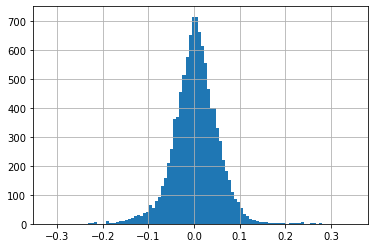

In [536]:
df.target_rgr.hist(bins=100)

delta_0%_3%      52.312111
delta_3%_100%    47.687889
Name: target_clf, dtype: float64


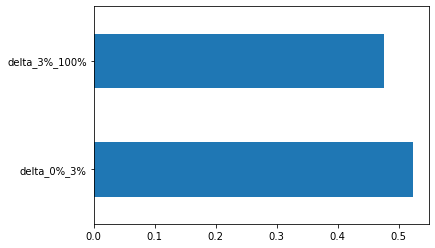

In [537]:
df.target_clf.value_counts(normalize=True).plot(kind='barh')
print(df.target_clf.value_counts(normalize=True)*100)

In [538]:
df.target_sign.value_counts(normalize=True)

 1.0    0.537195
-1.0    0.462805
Name: target_sign, dtype: float64

In [539]:
pd.crosstab(df.target_clf,df.target_sign,margins=True,normalize=True)

target_sign,-1.0,1.0,All
target_clf,,,
delta_0%_3%,0.253040,0.270081,0.523121
delta_3%_100%,0.209765,0.267113,0.476879
All,0.462805,0.537195,1.000000


### Clean dataset from NAs

In [543]:
import missingno as msno

In [541]:
print(f'current rows {df.shape[0]}')
print(f'max missing rows {df.isnull().sum().max()}')
print(f'opentime from {df.opentime.min().strftime("%Y-%m-%d %H:%M")} to {df.opentime.max().strftime("%Y-%m-%d %H:%M")}')
# msno.matrix(df.set_index('opentime')[df.columns[(df.isnull().sum()!=0)]],freq='H')

current rows 10465
max missing rows 335
opentime from 2021-01-01 00:00 to 2022-03-13 00:00


In [542]:
md = df.dropna().reset_index().copy()
md.shape

(10110, 202)

In [284]:
print(f'remaining missing observations {md.isnull().sum().sum()}')
print(f'current rows {md.shape[0]}')
print(f'opentime from {md.opentime.min().strftime("%Y-%m-%d %H:%M")} to {md.opentime.max().strftime("%Y-%m-%d %H:%M")}')

remaining missing observations 0
current rows 10278
opentime from 2021-01-07 23:00 to 2022-03-12 04:00


In [285]:
md.target_clf.value_counts()

delta_0%_3%      5414
delta_3%_100%    4864
Name: target_clf, dtype: int64

In [544]:
y = pd.Series(
    np.where( (md['target_clf']=='delta_3%_100%') & (md['target_sign']== 1) ,'P',
         np.where( (md['target_clf']=='delta_3%_100%') & (md['target_sign']== -1) ,'N', '0'))).reset_index(drop=True)
y.value_counts()

0    5374
P    2604
N    2132
dtype: int64

In [545]:
md['target_y'] = y

In [571]:
X = md[[x for x in md.columns if not (x.startswith('target') | x.endswith('time'))]].reset_index(drop=True)

In [548]:
# pd.Series(md.columns).to_clipboard()
# pd.Series(X.columns).to_clipboard()

### Temporal Train Test Split - dataset to test at the end

In [573]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [574]:
y, y_keep, X, X_keep = temporal_train_test_split(y,X,test_size=24*7*4)

In [575]:
[x.shape for x in [y, y_keep, X, X_keep]]

[(8766,), (672,), (8766, 197), (672, 197)]

In [576]:
y_keep.value_counts()

0    361
N    166
P    145
dtype: int64

### Setup Cross-Validation

In [577]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter

### sklearn TimeSeriesSplit

In [578]:
# tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=200)
tscv = TimeSeriesSplit(n_splits=10)
for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

(01) train : 0-805 [806] & test 806-1601 [796]
(02) train : 0-1601 [1602] & test 1602-2397 [796]
(03) train : 0-2397 [2398] & test 2398-3193 [796]
(04) train : 0-3193 [3194] & test 3194-3989 [796]
(05) train : 0-3989 [3990] & test 3990-4785 [796]
(06) train : 0-4785 [4786] & test 4786-5581 [796]
(07) train : 0-5581 [5582] & test 5582-6377 [796]
(08) train : 0-6377 [6378] & test 6378-7173 [796]
(09) train : 0-7173 [7174] & test 7174-7969 [796]
(10) train : 0-7969 [7970] & test 7970-8765 [796]


In [579]:
def TimeSeriesCV(X,y,n_splits=20, gap=0, max_train_size=None, test_size=None, verbose=False):
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, max_train_size=max_train_size, test_size=test_size)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        yield (X_train,y_train,X_test,y_test)

In [580]:
# tscv = TimeSeriesCV(X,y,n_splits=10,max_train_size=3000,test_size=24*7*4,verbose=True)
tscv = TimeSeriesCV(X,y,n_splits=10,verbose=True)

In [581]:
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-805 [806] & test 806-1601 [796]
(02) train : 0-1601 [1602] & test 1602-2397 [796]
(03) train : 0-2397 [2398] & test 2398-3193 [796]
(04) train : 0-3193 [3194] & test 3194-3989 [796]
(05) train : 0-3989 [3990] & test 3990-4785 [796]
(06) train : 0-4785 [4786] & test 4786-5581 [796]
(07) train : 0-5581 [5582] & test 5582-6377 [796]
(08) train : 0-6377 [6378] & test 6378-7173 [796]
(09) train : 0-7173 [7174] & test 7174-7969 [796]
(10) train : 0-7969 [7970] & test 7970-8765 [796]


In [582]:
tscv = TimeSeriesCV(X,y,n_splits=10,verbose=True)

In [583]:
X_train,y_train,X_test,y_test = next(tscv)
[len(x) for x in [X_train,y_train,X_test,y_test]]
X_train.tail()

(01) train : 0-805 [806] & test 806-1601 [796]


,index,open,high,low,close,volume,numtrade,...,fx_pp,fx_r1,fx_s1,fx_r2,fx_s2,fx_r3,fx_s3
801,10752,1807.500000,1813.040039,1793.140015,1804.260010,111030.968750,91187,...,1817.806641,1840.423340,1787.613281,1870.616699,1764.996582,1893.233398,1734.803223
802,10753,1804.260010,1825.000000,1802.020020,1816.119995,122213.906250,89345,...,1801.479980,1817.959961,1779.659912,1839.780029,1763.179932,1856.260010,1741.359863
803,10754,1816.130005,1828.000000,1806.000000,1812.670044,101273.960938,79428,...,1800.156616,1814.003174,1785.103271,1829.056641,1771.256714,1842.903076,1756.203369
804,10755,1812.680054,1820.000000,1808.739990,1812.020020,62523.871094,59019,...,1790.839966,1806.679932,1780.179932,1817.339844,1764.339966,1833.179932,1753.679932
805,10756,1812.010010,1852.390015,1811.000000,1832.599976,238306.890625,145220,...,1741.936646,1800.793335,1687.513306,1855.216675,1628.656616,1914.073364,1574.233276


### sktime SlidingWindowSplitter

In [584]:
tscv = SlidingWindowSplitter(window_length=1000, fh=list(range(1,(24*7+1))), step_length=1000)
n_splits = tscv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 8


In [585]:
for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

(01) train : 0-999 [1000] & test 1000-1167 [168]
(02) train : 1000-1999 [1000] & test 2000-2167 [168]
(03) train : 2000-2999 [1000] & test 3000-3167 [168]
(04) train : 3000-3999 [1000] & test 4000-4167 [168]
(05) train : 4000-4999 [1000] & test 5000-5167 [168]
(06) train : 5000-5999 [1000] & test 6000-6167 [168]
(07) train : 6000-6999 [1000] & test 7000-7167 [168]
(08) train : 7000-7999 [1000] & test 8000-8167 [168]


### sktime ExpandingWindowSplitter

In [586]:
tscv = ExpandingWindowSplitter(fh=list(range(1,(24*7+1))), step_length=1000)
n_splits = tscv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 9


In [587]:
for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

(01) train : 0-9 [10] & test 10-177 [168]
(02) train : 0-1009 [1010] & test 1010-1177 [168]
(03) train : 0-2009 [2010] & test 2010-2177 [168]
(04) train : 0-3009 [3010] & test 3010-3177 [168]
(05) train : 0-4009 [4010] & test 4010-4177 [168]
(06) train : 0-5009 [5010] & test 5010-5177 [168]
(07) train : 0-6009 [6010] & test 6010-6177 [168]
(08) train : 0-7009 [7010] & test 7010-7177 [168]
(09) train : 0-8009 [8010] & test 8010-8177 [168]


### Model Training - Single loop

In [588]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

In [589]:
# clf = RandomForestClassifier(class_weight='balanced')
clf = LGBMClassifier(class_weight='balanced')

In [591]:
[x.shape for x in (X_train,y_train)]

[(8010, 197), (8010,)]

In [592]:
clf.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced')

In [593]:
y_preds = clf.predict(X_keep)

In [594]:
accuracy_score(y_keep,y_preds)

0.5238095238095238

<AxesSubplot:ylabel='features'>

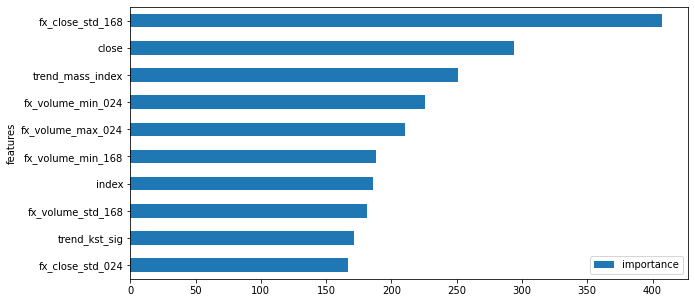

In [595]:
pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_}).set_index('features').sort_values(by=['importance']).tail(10).plot(kind='barh',figsize = (10,5))

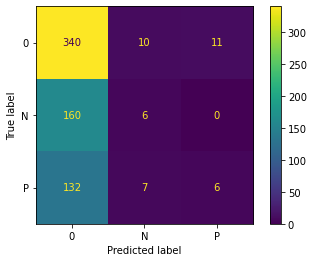

In [596]:
cm = confusion_matrix(y_keep,y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

In [597]:
pd.crosstab(y_keep,y_preds,margins=True)

col_0,0,N,P,All
row_0,,,,
0,340,10,11,361
N,160,6,0,166
P,132,7,6,145
All,632,23,17,672


In [598]:
print(classification_report(y_keep,y_preds))

              precision    recall  f1-score   support

           0       0.54      0.94      0.68       361
           N       0.26      0.04      0.06       166
           P       0.35      0.04      0.07       145

    accuracy                           0.52       672
   macro avg       0.38      0.34      0.27       672
weighted avg       0.43      0.52      0.40       672



### Model Training - Across all Folds

Wall time: 0 ns
(01) train : 0-2885 [2886] & test 2886-3557 [672]
Accuracy : 29.91%
              precision    recall  f1-score   support

           0       0.51      0.41      0.46       349
           N       0.00      0.00      0.00       183
           P       0.15      0.41      0.22       140

    accuracy                           0.30       672
   macro avg       0.22      0.27      0.23       672
weighted avg       0.30      0.30      0.28       672



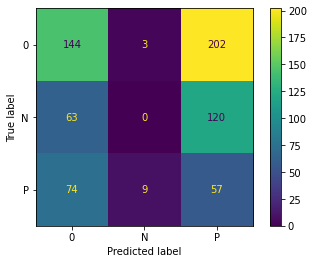

(02) train : 0-3557 [3558] & test 3558-4229 [672]
Accuracy : 28.57%
              precision    recall  f1-score   support

           0       0.51      0.32      0.39       349
           N       0.25      0.08      0.12       183
           P       0.17      0.49      0.25       140

    accuracy                           0.29       672
   macro avg       0.31      0.29      0.25       672
weighted avg       0.37      0.29      0.29       672



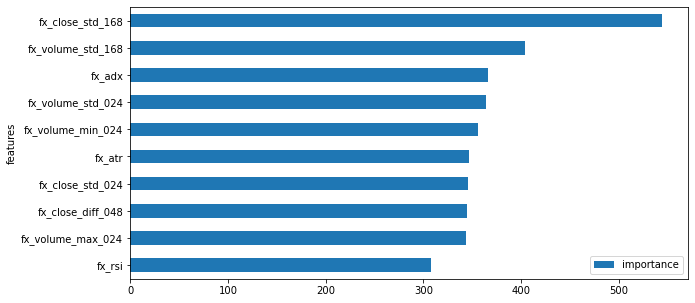

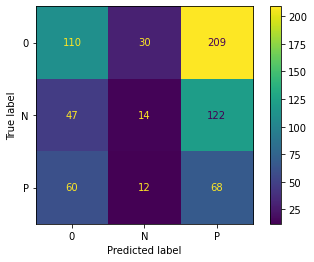

(03) train : 0-4229 [4230] & test 4230-4901 [672]
Accuracy : 28.87%
              precision    recall  f1-score   support

           0       0.50      0.35      0.41       349
           N       0.22      0.09      0.12       183
           P       0.16      0.40      0.23       140

    accuracy                           0.29       672
   macro avg       0.29      0.28      0.25       672
weighted avg       0.35      0.29      0.30       672



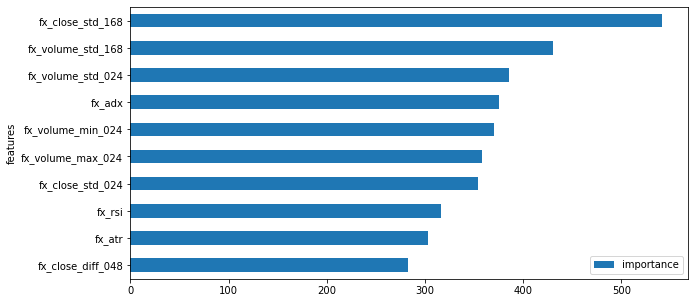

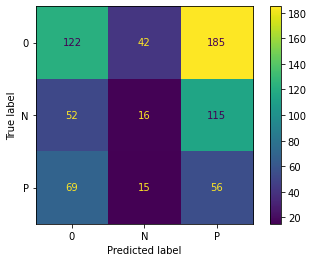

(04) train : 0-4901 [4902] & test 4902-5573 [672]
Accuracy : 30.80%
              precision    recall  f1-score   support

           0       0.52      0.40      0.46       349
           N       0.19      0.06      0.09       183
           P       0.16      0.39      0.23       140

    accuracy                           0.31       672
   macro avg       0.29      0.29      0.26       672
weighted avg       0.36      0.31      0.31       672



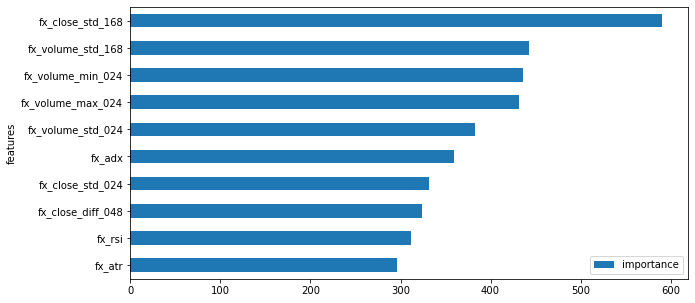

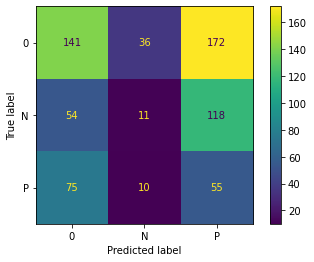

(05) train : 0-5573 [5574] & test 5574-6245 [672]
Accuracy : 29.32%
              precision    recall  f1-score   support

           0       0.54      0.32      0.40       349
           N       0.19      0.05      0.08       183
           P       0.18      0.54      0.27       140

    accuracy                           0.29       672
   macro avg       0.30      0.30      0.25       672
weighted avg       0.37      0.29      0.29       672



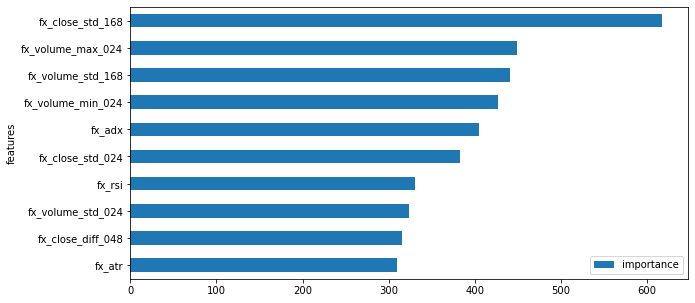

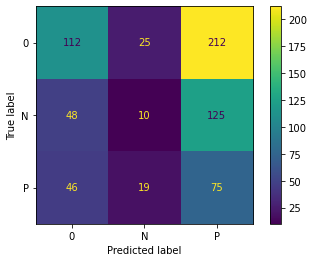

(06) train : 0-6245 [6246] & test 6246-6917 [672]
Accuracy : 31.10%
              precision    recall  f1-score   support

           0       0.52      0.34      0.41       349
           N       0.35      0.15      0.21       183
           P       0.17      0.44      0.25       140

    accuracy                           0.31       672
   macro avg       0.34      0.31      0.29       672
weighted avg       0.40      0.31      0.32       672



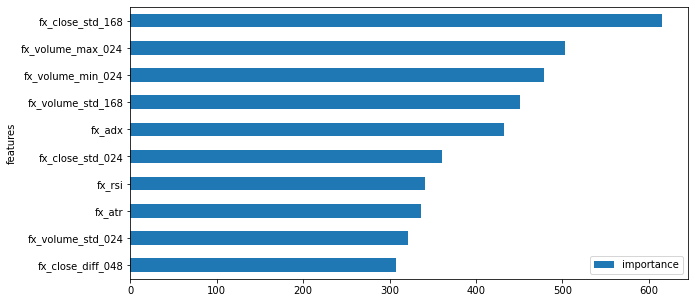

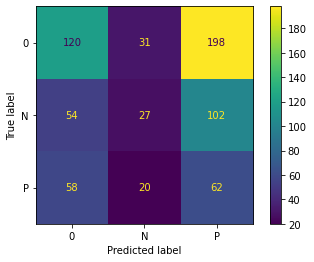

(07) train : 0-6917 [6918] & test 6918-7589 [672]
Accuracy : 33.48%
              precision    recall  f1-score   support

           0       0.50      0.46      0.48       349
           N       0.30      0.11      0.17       183
           P       0.15      0.31      0.21       140

    accuracy                           0.33       672
   macro avg       0.32      0.29      0.28       672
weighted avg       0.37      0.33      0.34       672



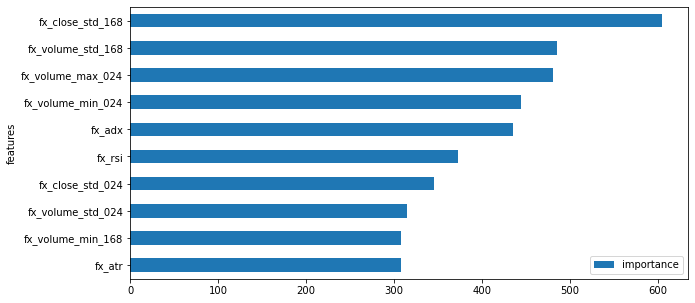

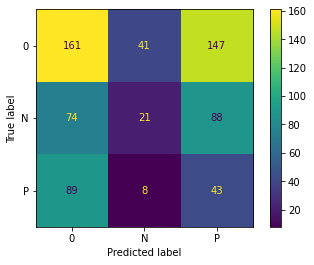

(08) train : 0-7589 [7590] & test 7590-8261 [672]
Accuracy : 34.08%
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       349
           N       0.41      0.15      0.22       183
           P       0.20      0.45      0.27       140

    accuracy                           0.34       672
   macro avg       0.36      0.33      0.31       672
weighted avg       0.41      0.34      0.34       672



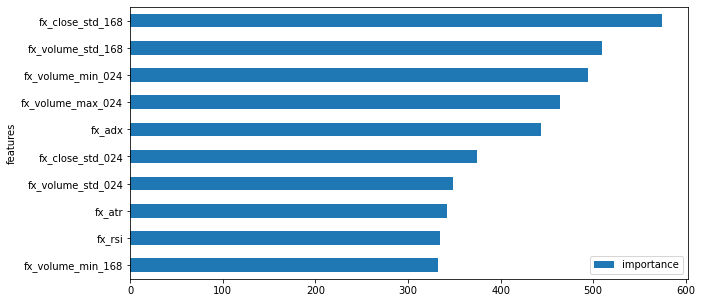

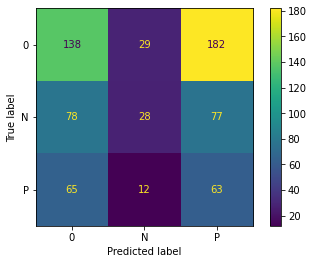

(09) train : 0-8261 [8262] & test 8262-8933 [672]
Accuracy : 34.52%
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       349
           N       0.38      0.15      0.21       183
           P       0.19      0.35      0.25       140

    accuracy                           0.35       672
   macro avg       0.34      0.31      0.30       672
weighted avg       0.38      0.35      0.34       672



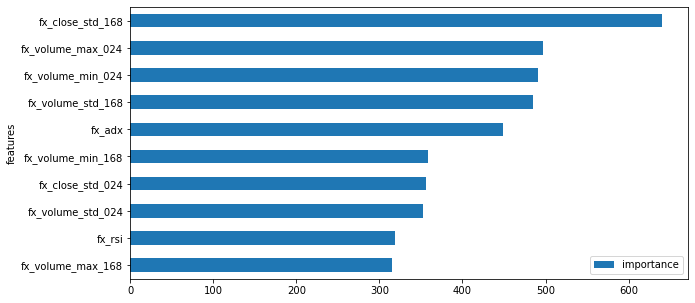

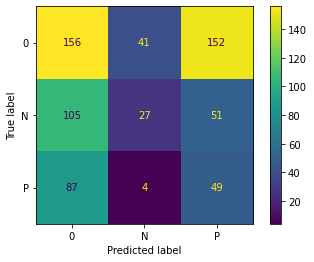

(10) train : 0-8933 [8934] & test 8934-9605 [672]
Accuracy : 35.12%
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       349
           N       0.30      0.07      0.11       183
           P       0.20      0.46      0.28       140

    accuracy                           0.35       672
   macro avg       0.34      0.33      0.29       672
weighted avg       0.39      0.35      0.34       672



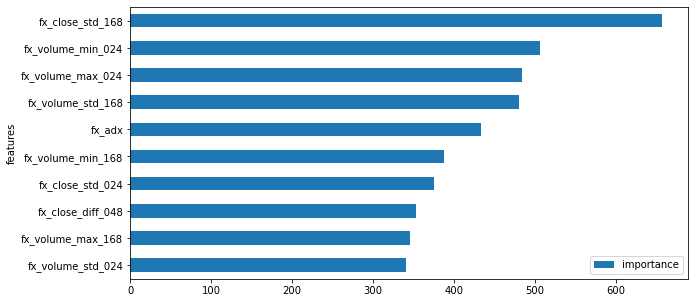

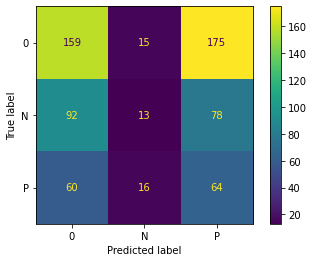

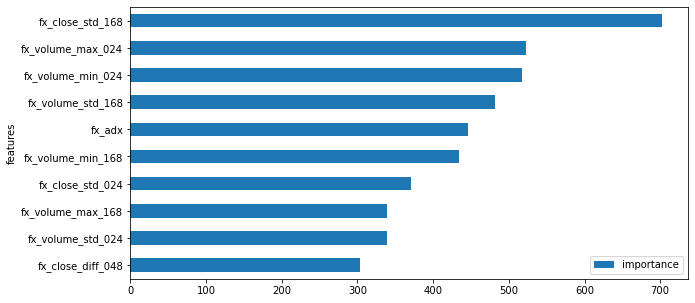

In [361]:
%time
tscv = TimeSeriesCV(X,y,n_splits=10,test_size=24*7*4,verbose=True)
for foo in tscv:
    
    X_train,y_train,X_test,y_test = foo
    #clf = RandomForestClassifier(n_estimators=1000,class_weight='balanced',)
    clf = LGBMClassifier(class_weight='balanced')
    clf.fit(X_train,y_train)
    y_preds = clf.predict(X_keep)
    
    print(f'Accuracy : {accuracy_score(y_keep,y_preds):.2%}')
    print(classification_report(y_keep,y_preds))
    
    cm = confusion_matrix(y_keep,y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
    disp.plot()
    plt.show()
    
    pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_}).set_index('features').sort_values(by=['importance']).tail(10).plot(kind='barh',figsize = (10,5))
    print(100*'=')